# Import python dataset

In [1]:
allow_pickle=True

In [2]:
notebookName = 'DCGAN.ipynb'

In [3]:
k = 816

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [5]:
import numpy as np
import functools
import time

import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.optimizers import Adam
from tensorflow import reduce_mean
import gc
from sklearn.preprocessing import *
import joblib
import matplotlib.ticker as mticker



In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6876219997975718750
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15683598464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3076661387539364786
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
Num GPUs Available:  1


In [7]:
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

In [8]:
tf.config.run_functions_eagerly(True)

In [9]:
os.makedirs('./output/Figures/Individual')
os.makedirs('./output/Figures/Result')
os.makedirs('./output/Figures/Prediction')
os.makedirs('./output/Figures/Loss')
os.makedirs('./ganmodels')

## Load data

In [10]:
n_features = 7

In [11]:
data= np.loadtxt('../input/pollutant/01.txt') 
print(data.shape)

data02= np.loadtxt('../input/pollutant/02.txt') 
print(data02.shape)

data04= np.loadtxt('../input/pollutant/04.txt') 
print(data04.shape)


groups = ['PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups = np.array(groups)
print(groups.shape)

groups2 = ['times','PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups2 = np.array(groups2)
print(groups.shape)

(1419, 7)
(1419, 7)
(1419, 7)
(6,)
(6,)


In [12]:
with open("../input/pollutant/10_2_time.csv", "r", encoding="utf-8") as fr:
    times = [fr.readlines()]
    
times = np.array(times)
times = times.T
print(times[:,0].shape)


(1419,)


<function matplotlib.pyplot.show(close=None, block=None)>

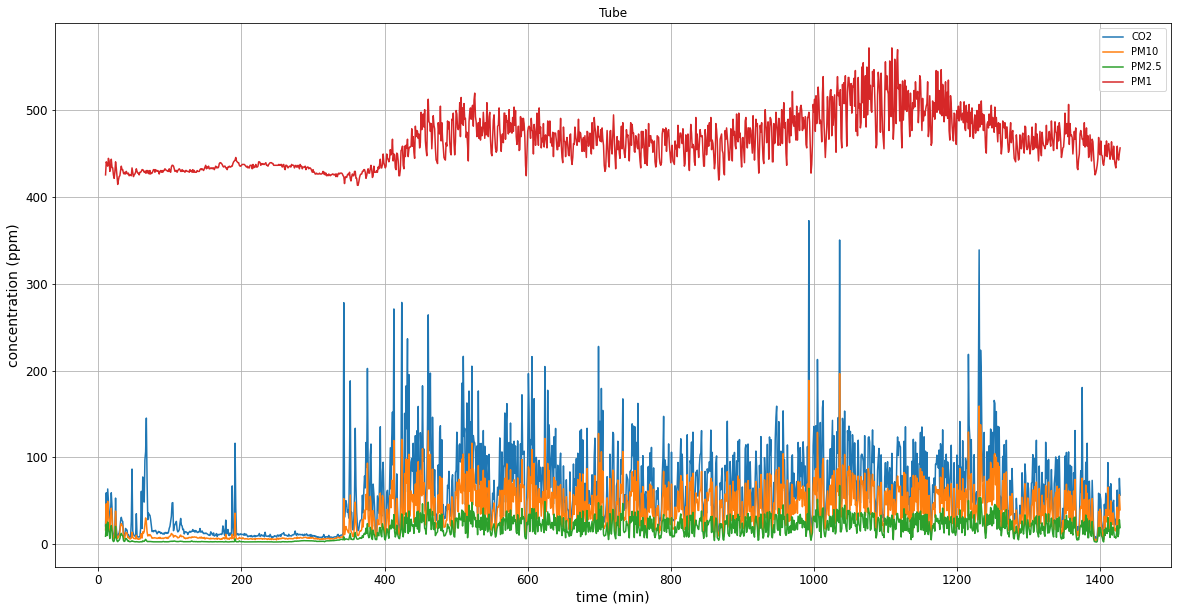

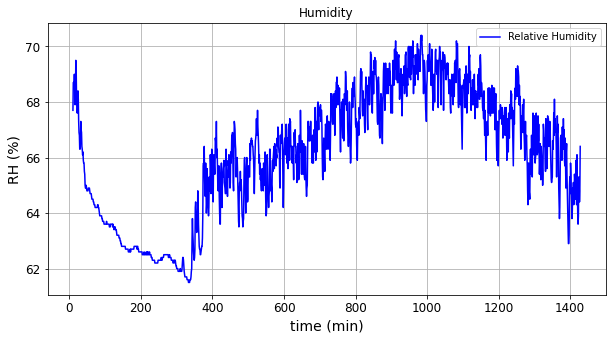

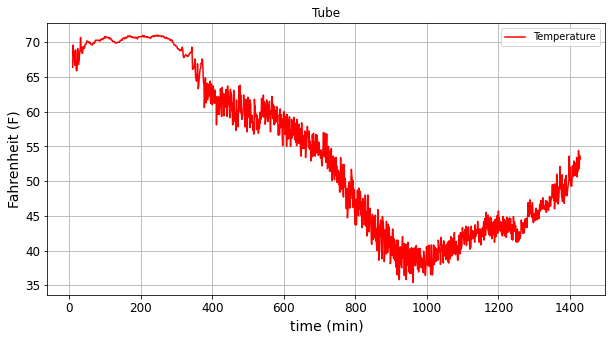

In [13]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(data[:,0], data[:,1], label='CO2')
ax.plot(data[:,0], data[:,2], label='PM10')
ax.plot(data[:,0], data[:,3], label='PM2.5')
ax.plot(data[:,0], data[:,4], label='PM1')

ax.grid()
plt.ylabel("concentration (ppm)")
plt.xlabel("time (min)")
plt.title('Tube')
plt.legend()
plt.savefig('./output/Figures/Sample'+'CO2+PM_v'+str(k)+'.png')

fig, ax = plt.subplots(1,1, figsize=[10,5])
ax.plot(data[:,0], data[:,5],c='blue', label='Relative Humidity')
ax.grid()
plt.ylabel("RH (%)")
plt.xlabel("time (min)")
plt.title('Humidity')
plt.legend()
plt.savefig('./output/Figures/Sample'+'RH_v'+str(k)+'.png')

fig, ax = plt.subplots(1,1, figsize=[10,5])
ax.plot(data[:,0], data[:,6],c='red', label='Temperature') #what is the unit?
ax.grid()
plt.ylabel("Fahrenheit (F)")
plt.xlabel("time (min)")
plt.title('Tube')
plt.legend()

plt.savefig('./output/Figures/Sample'+'Temp_v'+str(k)+'.png')
plt.show

# Preparing Dataset

In [14]:
codings_size = n_features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[-1,1])
X_train_scaled = scaler.fit_transform(data)

X_train_scaled.shape 


(1419, 7)

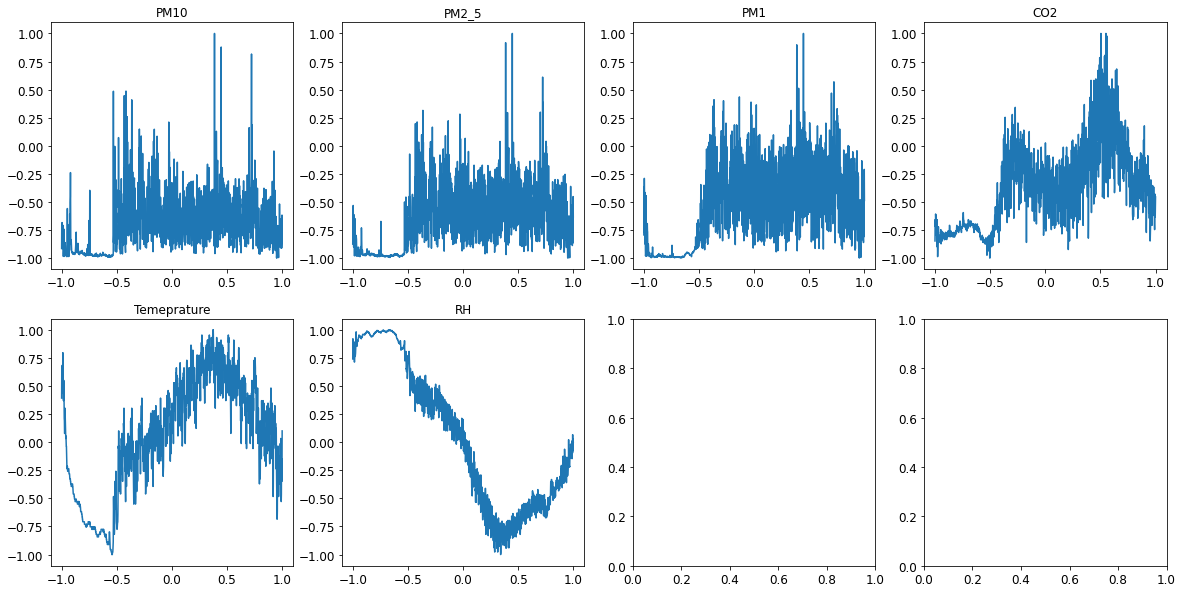

In [15]:
#plot the original dataset
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #a=i+1
    ax.flatten()[i].plot(X_train_scaled[:,0], X_train_scaled[:,i+1])
    ax.flatten()[i].set_title(group)
plt.savefig('./output/Figures/Individual/Sample'+'_v'+str(k)+'.png')

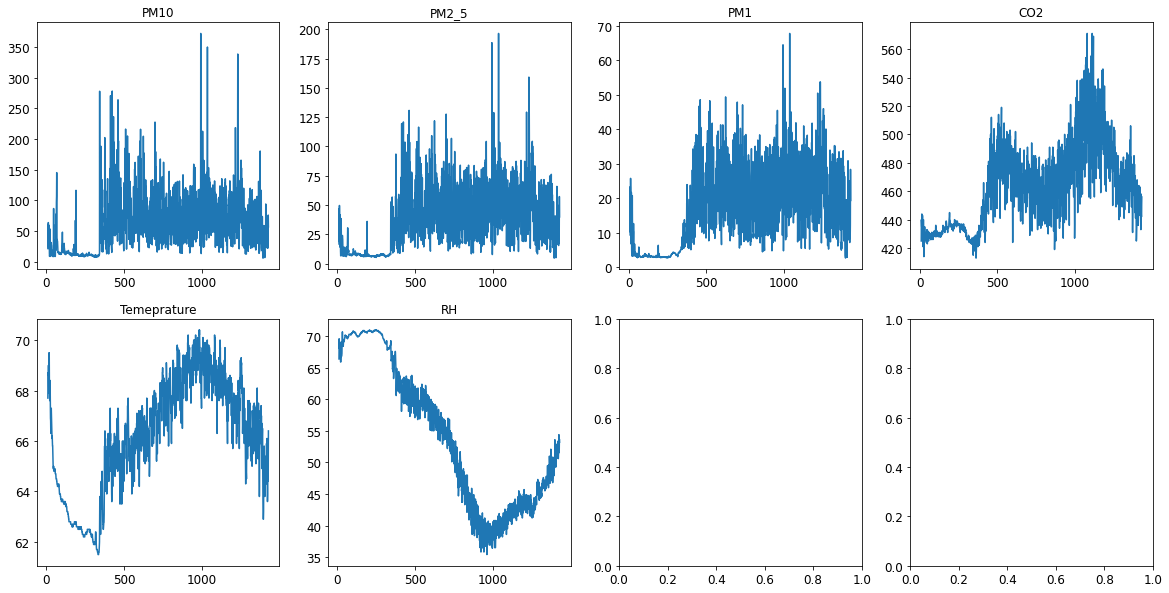

In [16]:
#scaler inverse_transform
X_train = scaler.inverse_transform(((X_train_scaled)))
X_train.shape 

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #a=i+1
    ax.flatten()[i].plot(X_train[:,0], X_train[:,i+1])
    ax.flatten()[i].set_title(group)
plt.savefig('./output/Figures/Individual/Sample'+'_v'+str(k)+'.png')

# Train the GAN

### Preparing the training dataset

In [17]:
n = 500

(1319, 100, 7, 1)
(100, 7, 1)


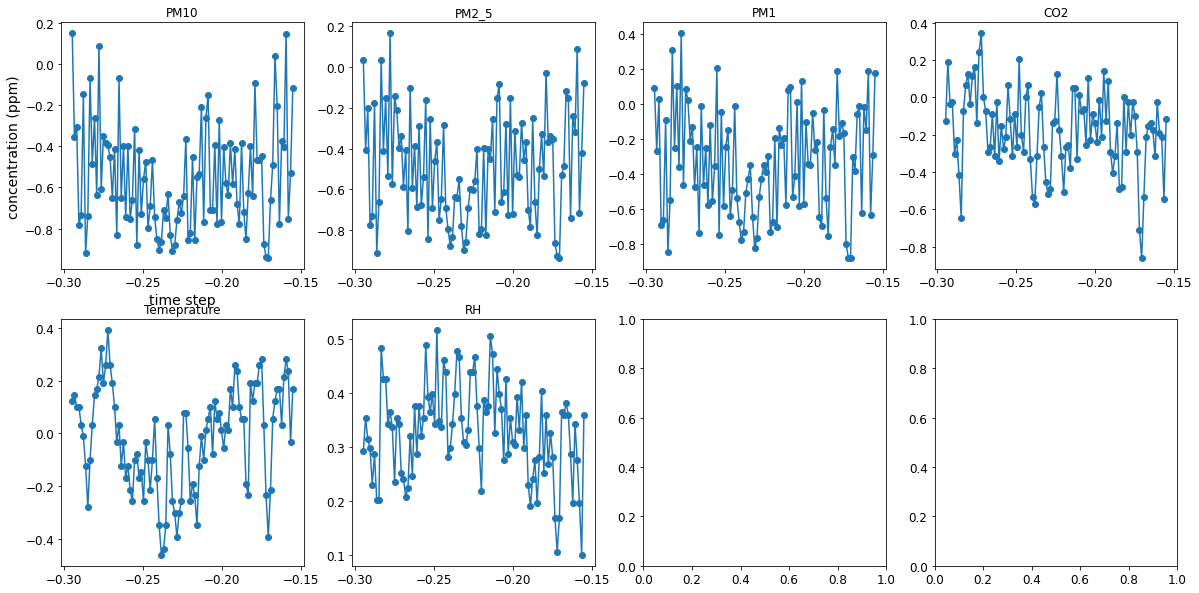

In [18]:
def concat_timesteps(X_train_scaled, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train_scaled) - ntimes*step):
        X_train_concat.append(X_train_scaled[i:i+ntimes*step:step])
    return np.array(X_train_concat)

ntimes = 100 # Consecutive times for the GAN
step = 1 # step between times (1 mins)

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)#X_train_scaled
X_train_concat = X_train_concat.reshape(X_train_concat.shape[0],ntimes,n_features,1)
print(X_train_concat.shape)
#Individual sample dataset


print(X_train_concat[n].shape)
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_concat[n][:,0,-1], X_train_concat[n][:,i+1,-1], '-o')
    ax.flatten()[i].set_title(group)
    ax.flatten()[0].set_xlabel("time step")
    ax.flatten()[0].set_ylabel("concentration (ppm)")



In [19]:
BATCH_SIZE = 32
latent_space = 100

# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], ntimes, n_features,1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_scaled))
train_dataset = train_dataset.batch(BATCH_SIZE)

for data in train_dataset:
    print(data.shape)
    break

(32, 100, 7, 1)


### Building model

In [20]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [21]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(128 * ntimes * n_features, activation="relu", input_dim=latent_space))
    model.add(Reshape((ntimes, n_features, 128)))
    
    #model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    #model.add(UpSampling2D())
    
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model

generator = make_generator_model()
generator.summary()


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=[ntimes,n_features,1], padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = make_discriminator_model()
discriminator.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 89600)             9049600   
_________________________________________________________________
reshape (Reshape)            (None, 100, 7, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 7, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 7, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 100, 7, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 7, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 7, 64)        2

In [22]:
#gan = keras.models.Sequential([generator, discriminator])

# Define Training 

In [23]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

# The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)

# logs to follow losses on tensorboard
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './logs/DCGAN/generator'
discriminator_log_dir = './logs/DCGAN/discriminator'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    if batch.shape[0]==BATCH_SIZE:
        noise = tf.random.normal([BATCH_SIZE, latent_space])
    else:
        noise = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space])
        noise = noise.numpy()
        noise = noise.astype('float32')

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    generator_mean_loss(gen_loss)
    discriminator_mean_loss(disc_loss)

In [24]:
def generated_data(latent_space, X_train_concat, ntimes, n_features, groups, epoch):
    n_instances = X_train_concat.shape[0]
    noise = tf.random.normal([n_instances, latent_space])
    generated_image = generator(noise, training=False)
    print(generated_image.shape)
    
    generated_image = generated_image.numpy()
    generated_image = generated_image.reshape(n_instances*ntimes, n_features)
    generated_image = scaler.inverse_transform(generated_image)

    fig, ax = plt.subplots(2,4, figsize=[20,10])

    for i, group in enumerate(groups):
        ax.flatten()[i].plot(generated_image[:,0],generated_image[:,i+1],'o',c='orange')
        ax.flatten()[i].set_title(group)
        ax.flatten()[0].set_xlabel("time step")
        ax.flatten()[0].set_ylabel("concentration (ppm)")
    
    plt.savefig('./output/Figures/Result/result_DCGAN_v'+str(k)+'_epoch_'+str(epoch+1)+'.png')
    plt.show()
    print('save generated image')


In [25]:
def train(dataset, epochs):
    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch+1, epochs))   

        for batch in dataset:
            train_step(batch)
            
        with generator_summary_writer.as_default():
            tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)
        with discriminator_summary_writer.as_default():
            tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
        
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        
        print("discriminator: {:.6f}".format(hist[-1][1]), end=' - ')
        print("generator: {:.6f}".format(hist[-1][0]), end=' - ')    
        print ('{:.0f}s'.format( time.time()-start))


        # Global variables are used below
        if (epoch+1)%1000 == 0: 
            # Save model
            gan.save('./ganmodels/DCGAN_v'+str(k)+'_epoch_'+str(epoch+1)+'.h5')    
            
            # plot loss
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_gen', 'loss_disc'])
            ax.grid()
            plt.savefig('./output/Figures/Loss/loss'+'_v'+str(k)+str(epoch+1)+'.png')
            plt.show()
            
            #plot generated_data
            generated_data(latent_space, X_train_concat, ntimes, n_features, groups, epoch)
            
            
            
            
    return hist


# Formally Training

In [26]:
epochs = 50000

In [27]:
#hist = train(train_dataset, epochs=epochs)#55000

In [28]:
gan = tf.keras.models.load_model('../input/ganmodels/DCGAN_v816_epoch_4000.h5',).layers
generator, discriminator = tf.keras.models.load_model('../input/ganmodels/DCGAN_v816_epoch_4000.h5').layers  

# Generated Data

(131900, 7)
save generated image


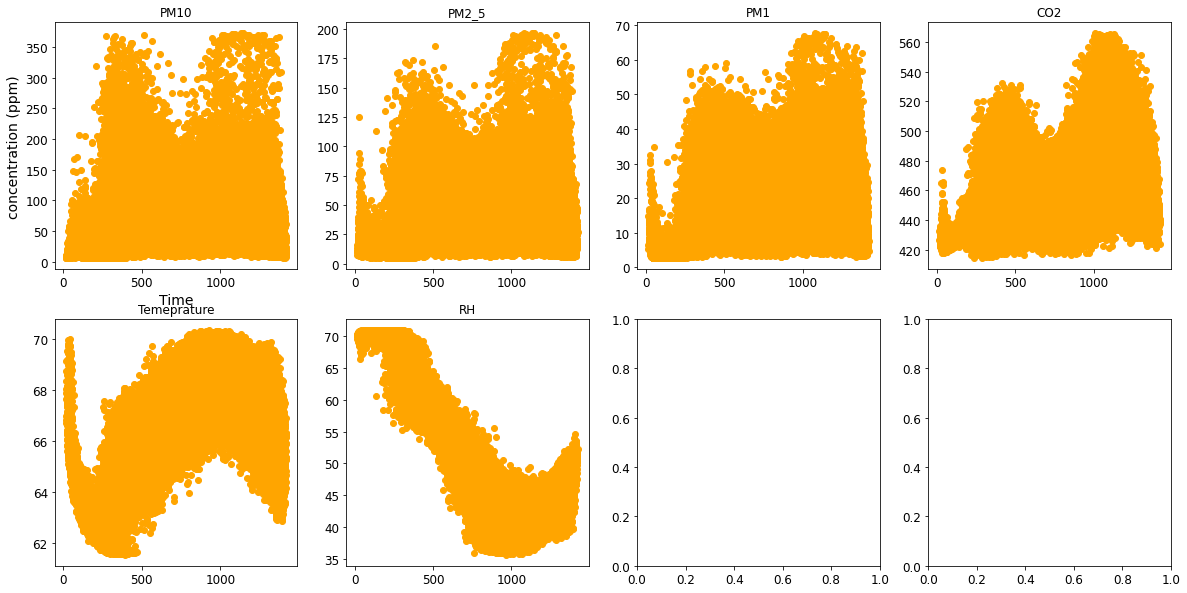

In [29]:
#generated data
n_instances = X_train_concat.shape[0]
noise = tf.random.normal([n_instances, latent_space])
generated_image = generator(noise, training=False)
generated_image = generated_image.numpy()
generated_image = generated_image.reshape(n_instances*ntimes*1, n_features)
generated_image = scaler.inverse_transform(generated_image)


print(generated_image.shape)

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(generated_image[:,0],generated_image[:,i+1],'o',c='orange')

        
    ax.flatten()[i].set_title(group)
    ax.flatten()[0].set_xlabel("Time")
    ax.flatten()[0].set_ylabel("concentration (ppm)")
    
plt.savefig('./output/Figures/Result/result+_v'+str(k)+'.png')
print('save generated image')


(131900, 7)


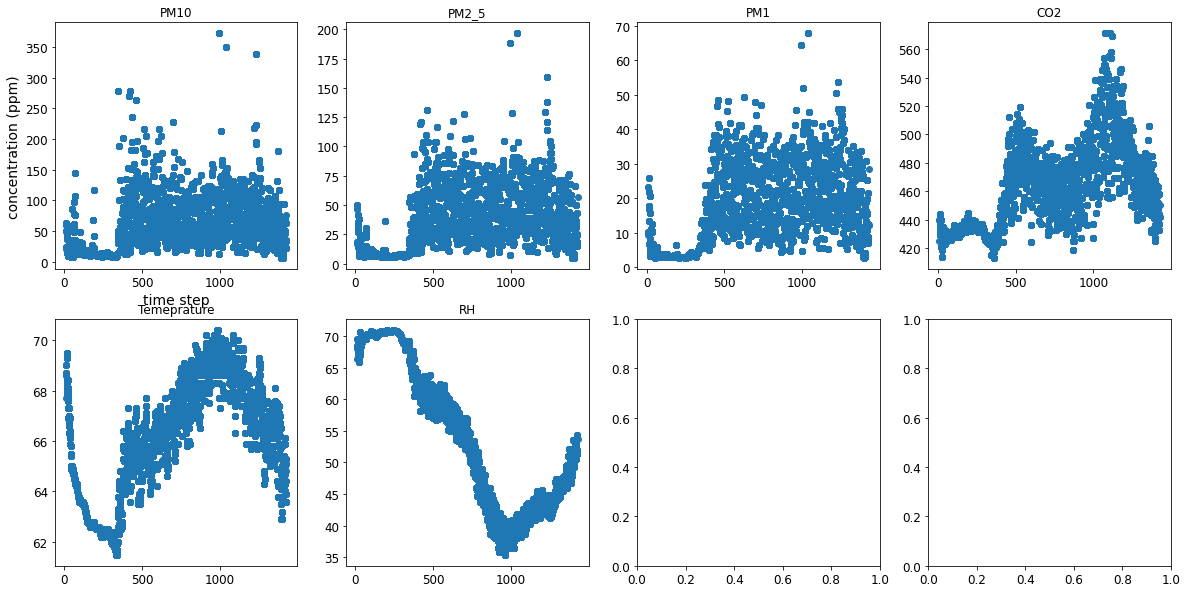

In [30]:
X_train_concat_flatten2 = X_train_concat.reshape(X_train_concat.shape[0]*ntimes, n_features).astype('float32')
X_train_concat_flatten2 = scaler.inverse_transform(X_train_concat_flatten2)
print(X_train_concat_flatten2.shape)

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_concat_flatten2[:,0],X_train_concat_flatten2[:,i+1],'o')

    ax.flatten()[i].set_title(group)
    ax.flatten()[0].set_xlabel("time step")
    ax.flatten()[0].set_ylabel("concentration (ppm)")    
    
plt.savefig('./output/Figures/Result/sample_v'+str(k)+'.png')

# Covariance: 

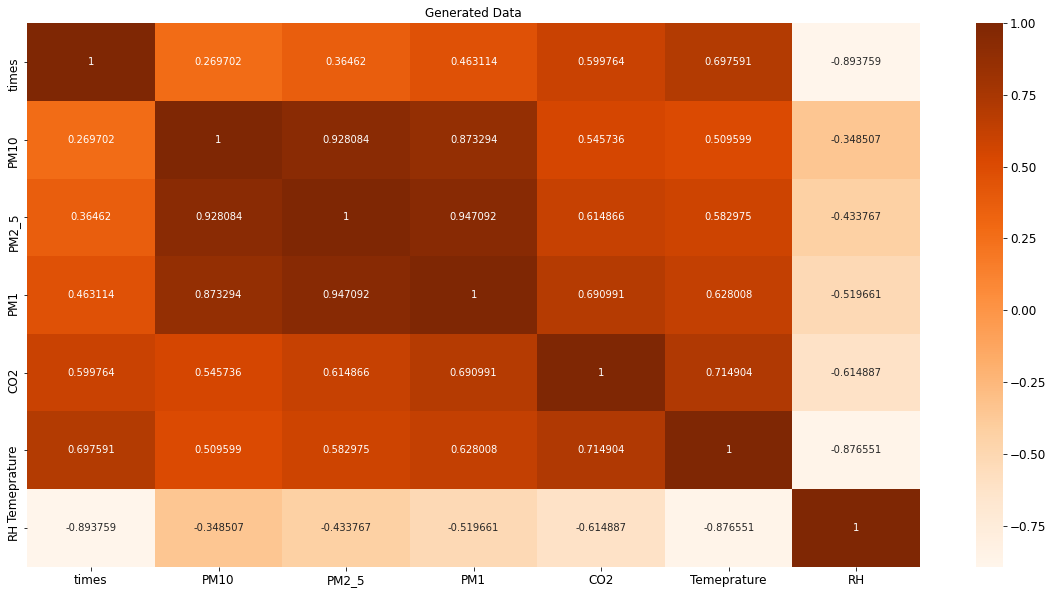

In [31]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns



data = np.array([generated_image[:,0],generated_image[:,1],generated_image[:,2],generated_image[:,3],generated_image[:,4],generated_image[:,5],generated_image[:,6]])
covMatrix = np.corrcoef(data)
fig, ax = plt.subplots(figsize=(20,10)) 

# create seabvorn heatmap with required labels
sns.heatmap(covMatrix, annot=True, fmt='g',cmap="Oranges", ax=ax, xticklabels=groups2, yticklabels=groups2)
plt.title('Generated Data')
plt.savefig('./output/Figures/Result/Covariance_generated_DCGAN_v'+str(k)+'.png')
plt.show()


# Predict with the GAN

## Predict one point (start at n=0)

In [32]:
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)

#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [33]:
n = 0
epochs = 10000 

In [34]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(2e-2) #1e-4

def mse_loss(inp, outp):
    inp = tf.reshape(inp, [-1, n_features]) 
    outp = tf.reshape(outp, [-1, n_features])
    print("input:",inp.shape)
    print("output:",outp.shape)
    
    return mse(inp, outp)

input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (

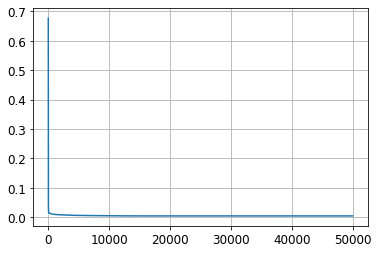

In [35]:
@tf.function
def opt_step(latent_values, real_coding):
    #with tpu_strategy.scope():
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss



def optimize_coding(real_coding):
    latent_values = tf.random.normal([len(real_coding), latent_space])  
    latent_values = tf.Variable(latent_values) #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(epochs): #20000
        loss.append(opt_step(latent_values, real_coding).numpy())
        
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output


X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], n_features*ntimes).astype('float32')

n = n #n=100
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)


latent_values = optimize_coding(real_coding)


print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:], real_coding).numpy())


print(latent_values)

X_generated :  (100, 7)
X_real :  (100, 7)


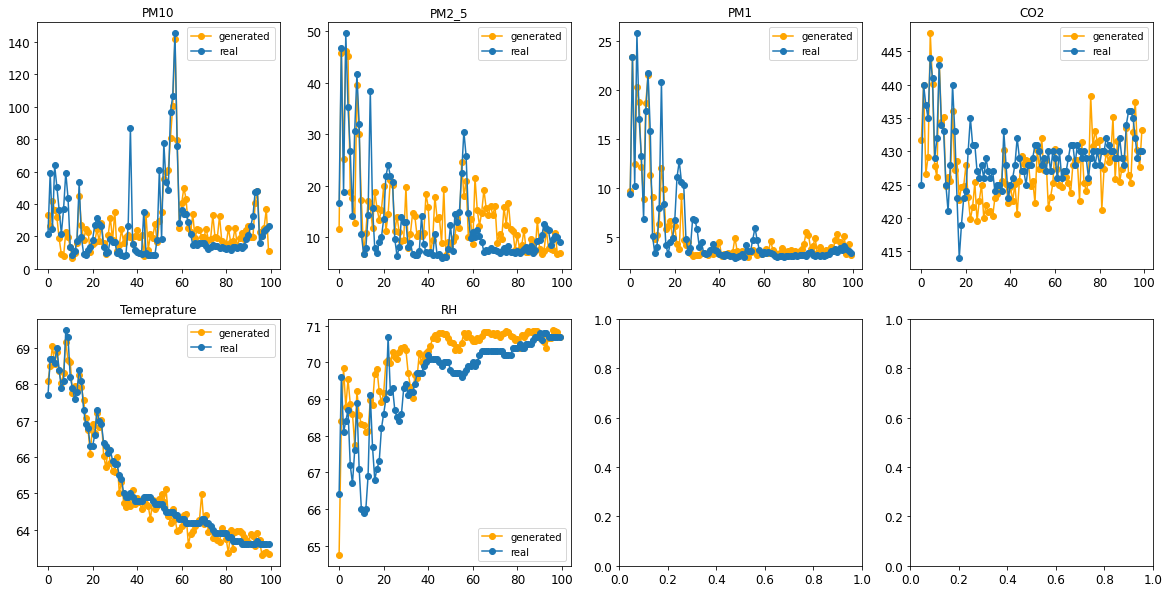

In [36]:
X_generated = generator(latent_values).numpy()
X_generated = scaler.inverse_transform((X_generated.reshape(ntimes, n_features)))
print('X_generated : ',X_generated.shape)


X_real = scaler.inverse_transform((X_train_concat_flatten[n].reshape(ntimes, n_features)))
X_real = X_real.reshape(ntimes, n_features)
print('X_real : ',X_real.shape)


fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i+1], '-o',c='orange', label='generated')
    ax.flatten()[i].plot(X_real[:,i+1], '-o', label='real')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/one_point_v'+str(k)+'_epoch_'+str(epochs)+'.png')

## Predict 30 points

**In this section we predict multiple points. We use the last predictions as the points to data assimilate in the next prediction** 

n = n #0
epochs2 = 50000 #2000
predict_points = 30

def optimize_coding(latent_values, real_coding, epochs=epochs2):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding)
        
    return latent_values  #returns the optimized input that generates the desired output


@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[-1,:(ntimes - 1),:])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss


np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs=epochs2)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs=epochs2)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), len(groups2))
X_generated[X_generated<0] = 0 

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i+1], '-o',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-o', label='real')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/multiple_point_DCGAN_v'+str(k)+'_epoch_'+str(epochs2)+'.png')

# Predict the whole simulation

In [37]:
epochs2 = 10000 #2000

epochs3 = 1000
n = n
predict_points = X_train.shape[0]-n-ntimes

In [38]:
def optimize_coding(latent_values, real_coding, epochs=epochs3):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding)
        
    return latent_values  #returns the optimized input that generates the desired output


@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[-1,:(ntimes - 1),:])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss


np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs=epochs3)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (99, 7)
output: (99, 7)
input: (

KeyboardInterrupt: 

In [ ]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), len(groups2))
X_generated[X_generated<0] = 0 
np.save('X_generatedall.npy',X_generated)

print(X_generated.shape)
print(X_train.shape)

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/entire'+str(k)+'_epoch_'+str(epoch)+'.png')

# All Day

In [ ]:
n = 500
epochs = 50000 

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(2e-2) #1e-4

def mse_loss(inp, outp):
    inp = tf.reshape(inp, [-1, n_features]) 
    outp = tf.reshape(outp, [-1, n_features])
    print("input:",inp.shape)
    print("output:",outp.shape)
    
    return mse(inp, outp)

In [ ]:
@tf.function
def opt_step(latent_values, real_coding):
    #with tpu_strategy.scope():
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss



def optimize_coding(real_coding):
    latent_values = tf.random.normal([len(real_coding), latent_space])  
    latent_values = tf.Variable(latent_values) #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(epochs): #20000
        loss.append(opt_step(latent_values, real_coding).numpy())
        
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output


X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], n_features*ntimes).astype('float32')

n = n #n=100
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)


latent_values = optimize_coding(real_coding)


print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:], real_coding).numpy())


print(latent_values)

In [ ]:
X_generated = generator(latent_values).numpy()
X_generated = scaler.inverse_transform((X_generated.reshape(ntimes, n_features)))
print('X_generated : ',X_generated.shape)


X_real = scaler.inverse_transform((X_train_concat_flatten[n].reshape(ntimes, n_features)))
X_real = X_real.reshape(ntimes, n_features)
print('X_real : ',X_real.shape)


fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i+1], '-o',c='orange', label='generated')
    ax.flatten()[i].plot(X_real[:,i+1], '-o', label='real')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/00one_point_v'+str(k)+'_epoch_'+str(epochs)+'.png')

In [ ]:
epochs2 = 50000 #2000

epochs3 = 1000
n = n
predict_points = X_train.shape[0]-n-ntimes

In [ ]:
def optimize_coding(latent_values, real_coding, epochs=epochs3):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding)
        
    return latent_values  #returns the optimized input that generates the desired output


@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[-1,:(ntimes - 1),:])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss


np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs=epochs3)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [ ]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), len(groups2))
X_generated[X_generated<0] = 0 
np.save('X_generatedall.npy',X_generated)

print(X_generated.shape)
print(X_train.shape)

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/00entire'+str(k)+'_epoch_'+str(epoch)+'.png')